Necessary imports

In [ ]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score

if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])


Data Loading and Preprocessing to compare the algorithms, although Decision Trees are not sensitve to feature scalling, they do not use geometric distances


In [4]:
import data_prep

X_train, X_val, X_test, y_train, y_val, y_test, feature_names = data_prep.load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))
print(X_train.shape, X_val.shape, X_test.shape)
print(feature_names)

(31206, 37) (10402, 37) (10403, 37)
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')


NGBoost for outputting Probalitiy Distribution instead of single value https://stanfordmlgroup.github.io/ngboost/1-useage.html

In [4]:
# necessary imports for NGBoost
from ngboost import NGBRegressor
from ngboost.scores import LogScore
from ngboost.distns import  Normal
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


Eigene Loop für Grid Search, um mit einem festen Val Set zu arbeiten und dann Early Stopping implementieren, GridSearchCV nur mit Cross Validation und ohne Early Stopping möglich von sklearn

In [ ]:
# define the hyperparameter grid    
param_grid = {
    'n_estimators': [ 200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 8, 10, 12, 14],
}

best_score = float('inf')
best_params = None
scores = []
# Loop through all combinations of hyperparameters
for max_depth in param_grid['max_depth']:
    for n_estimators in param_grid['n_estimators']:
        for learning_rate in param_grid['learning_rate']:
            # Create a new NGBRegressor with the current hyperparameters
            ngb = NGBRegressor(
                Dist=Normal, 
                Score=LogScore, 
                Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=max_depth),
                verbose=True, 
                n_estimators=n_estimators, 
                learning_rate=learning_rate
            )
            
            # Fit the model to the training data
            ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=20)
            
            # Make predictions on the validation set
            y_preds = ngb.predict(X_val)
            y_dists = ngb.pred_dist(X_val)
            
            # Calculate the mean squared error
            mse = mean_squared_error(y_val, y_preds)
            
            # Calculate R²
            r2 = r2_score(y_val, y_preds)
        
            # Calculate the negative log likelihood
            # Note: The logpdf method returns the log probability density function
            # for the predicted distribution at the given values
            nll = -y_dists.logpdf(y_val).mean()
            
            # Print the results            
            print(f"n_estimators: {n_estimators}, learning_rate: {learning_rate}, max_depth: {max_depth}, MSE: {mse:.3f}, R²: {r2:.3f}, Negative Log Likelihood: {nll:.3f}")
            
            # log the scores
            scores.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'mse': mse,
                'r2': r2,
                'nll': nll
            })
            # Check if this is the best score so far
            if nll < best_score:
                best_score = nll
                best_params = {
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'max_depth': max_depth
                }
     

In [ ]:
# get the best parameters, lists for nll, R2 and MSE
# list contains at each position a list element with the score and the parameters dictonary
negLL = []
r2_lst = []
mse = []
for s in scores:
    mse.append([s['mse'],s])
    r2_lst.append([s['r2'],s])
    negLL.append([s['nll'],s])

print(f"best negativ log likelyhood {min(negLL)}")
print(f" best R2-Score {max(r2_lst)}")
print(f" best MSE {min(mse)}")

Optuna Hyperparameter Search

In [6]:
import optuna
from optuna.trial import TrialState

def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step = 50)
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.1, log=True)
    max_depth = trial.suggest_int("max_depth", 4, 20)
    
    # Create the NGBRegressor model with the suggested hyperparameters
    ngb = NGBRegressor(
        Dist=Normal, 
        Score=LogScore, 
        Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=max_depth),
        verbose=False, 
        n_estimators=n_estimators, 
        learning_rate=learning_rate
    )
    
    # Fit the model to the training data
    ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=20)
    
    # Make predictions on the validation set
    y_preds = ngb.predict(X_val)
    y_dists = ngb.pred_dist(X_val)
    
    # Calculate the negative log likelihood
    nll = -y_dists.logpdf(y_val).mean()
    mse = mean_squared_error(y_val, y_preds)
    
    return nll

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler()
    )
study.optimize(objective, n_trials=50, timeout=None, n_jobs=1, show_progress_bar=True)

print(study.best_params)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))



[I 2025-07-12 12:35:34,640] A new study created in memory with name: no-name-eacf7bba-856a-41bc-a663-7a8be263add3
Best trial: 0. Best value: 2.4974:   2%|▏         | 1/50 [03:31<2:52:42, 211.47s/it]

[I 2025-07-12 12:39:06,096] Trial 0 finished with value: 2.4973956744195944 and parameters: {'n_estimators': 750, 'learning_rate': 0.004696012481494186, 'max_depth': 17}. Best is trial 0 with value: 2.4973956744195944.


Best trial: 1. Best value: 2.34182:   4%|▍         | 2/50 [06:52<2:44:13, 205.28s/it]

[I 2025-07-12 12:42:27,042] Trial 1 finished with value: 2.341823927543504 and parameters: {'n_estimators': 1000, 'learning_rate': 0.004963701530767905, 'max_depth': 9}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:   6%|▌         | 3/50 [15:51<4:40:04, 357.55s/it]

[I 2025-07-12 12:51:25,797] Trial 2 finished with value: 3.040454475228223 and parameters: {'n_estimators': 950, 'learning_rate': 0.0003162921721112974, 'max_depth': 13}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:   8%|▊         | 4/50 [18:21<3:31:32, 275.93s/it]

[I 2025-07-12 12:53:56,627] Trial 3 finished with value: 2.920689277494671 and parameters: {'n_estimators': 400, 'learning_rate': 0.00157928350503895, 'max_depth': 8}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  10%|█         | 5/50 [18:43<2:18:09, 184.21s/it]

[I 2025-07-12 12:54:18,193] Trial 4 finished with value: 4.438886442961866 and parameters: {'n_estimators': 250, 'learning_rate': 0.0810067795527444, 'max_depth': 12}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  12%|█▏        | 6/50 [20:45<1:59:35, 163.08s/it]

[I 2025-07-12 12:56:20,257] Trial 5 finished with value: 3.106478082502451 and parameters: {'n_estimators': 150, 'learning_rate': 0.0014010917505873045, 'max_depth': 20}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  14%|█▍        | 7/50 [27:02<2:46:55, 232.92s/it]

[I 2025-07-12 13:02:36,970] Trial 6 finished with value: 3.105431799366439 and parameters: {'n_estimators': 500, 'learning_rate': 0.0004246233614159027, 'max_depth': 18}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  16%|█▌        | 8/50 [28:32<2:11:15, 187.52s/it]

[I 2025-07-12 13:04:07,273] Trial 7 finished with value: 2.3869690578904006 and parameters: {'n_estimators': 200, 'learning_rate': 0.007894281386656769, 'max_depth': 10}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  18%|█▊        | 9/50 [32:36<2:20:14, 205.24s/it]

[I 2025-07-12 13:08:11,475] Trial 8 finished with value: 2.5611949171724477 and parameters: {'n_estimators': 900, 'learning_rate': 0.0032057910712470074, 'max_depth': 5}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  20%|██        | 10/50 [36:31<2:22:50, 214.27s/it]

[I 2025-07-12 13:12:05,965] Trial 9 finished with value: 2.5434858271963554 and parameters: {'n_estimators': 1000, 'learning_rate': 0.007654002256328026, 'max_depth': 4}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  22%|██▏       | 11/50 [37:11<1:44:35, 160.92s/it]

[I 2025-07-12 13:12:45,919] Trial 10 finished with value: 2.3531993786385885 and parameters: {'n_estimators': 700, 'learning_rate': 0.032953181214473895, 'max_depth': 8}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  24%|██▍       | 12/50 [37:42<1:16:50, 121.32s/it]

[I 2025-07-12 13:13:16,685] Trial 11 finished with value: 2.3541967350953423 and parameters: {'n_estimators': 700, 'learning_rate': 0.04605286124303831, 'max_depth': 8}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  26%|██▌       | 13/50 [39:06<1:07:52, 110.07s/it]

[I 2025-07-12 13:14:40,871] Trial 12 finished with value: 2.356114332762589 and parameters: {'n_estimators': 750, 'learning_rate': 0.022084603107847524, 'max_depth': 7}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  28%|██▊       | 14/50 [40:07<57:12, 95.35s/it]   

[I 2025-07-12 13:15:42,199] Trial 13 finished with value: 2.528231613260621 and parameters: {'n_estimators': 600, 'learning_rate': 0.017883042426965323, 'max_depth': 14}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  30%|███       | 15/50 [46:32<1:46:36, 182.77s/it]

[I 2025-07-12 13:22:07,557] Trial 14 finished with value: 3.3427320260926026 and parameters: {'n_estimators': 850, 'learning_rate': 0.00010272944482385428, 'max_depth': 10}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  32%|███▏      | 16/50 [48:09<1:28:48, 156.71s/it]

[I 2025-07-12 13:23:43,743] Trial 15 finished with value: 2.393471552256133 and parameters: {'n_estimators': 400, 'learning_rate': 0.02035639494704343, 'max_depth': 6}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  34%|███▍      | 17/50 [48:27<1:03:19, 115.15s/it]

[I 2025-07-12 13:24:02,221] Trial 16 finished with value: 2.831022927291224 and parameters: {'n_estimators': 600, 'learning_rate': 0.09841406604427472, 'max_depth': 10}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  36%|███▌      | 18/50 [49:04<48:55, 91.75s/it]   

[I 2025-07-12 13:24:39,521] Trial 17 finished with value: 3.045490929865345 and parameters: {'n_estimators': 850, 'learning_rate': 0.036267259545273996, 'max_depth': 15}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  38%|███▊      | 19/50 [50:35<47:17, 91.54s/it]

[I 2025-07-12 13:26:10,569] Trial 18 finished with value: 2.3742703389886914 and parameters: {'n_estimators': 1000, 'learning_rate': 0.010545072284846673, 'max_depth': 11}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  40%|████      | 20/50 [55:02<1:12:02, 144.07s/it]

[I 2025-07-12 13:30:37,079] Trial 19 finished with value: 2.6519525524052385 and parameters: {'n_estimators': 700, 'learning_rate': 0.0015696963893317528, 'max_depth': 8}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  42%|████▏     | 21/50 [57:35<1:11:00, 146.92s/it]

[I 2025-07-12 13:33:10,626] Trial 20 finished with value: 3.1775146480330663 and parameters: {'n_estimators': 500, 'learning_rate': 0.0007749541937812128, 'max_depth': 6}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  44%|████▍     | 22/50 [58:04<51:54, 111.23s/it]  

[I 2025-07-12 13:33:38,642] Trial 21 finished with value: 2.3684257893205354 and parameters: {'n_estimators': 700, 'learning_rate': 0.04876418935739891, 'max_depth': 8}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  46%|████▌     | 23/50 [58:34<39:10, 87.06s/it] 

[I 2025-07-12 13:34:09,309] Trial 22 finished with value: 2.3965754413676073 and parameters: {'n_estimators': 800, 'learning_rate': 0.04274195283271753, 'max_depth': 9}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  48%|████▊     | 24/50 [1:00:45<43:26, 100.24s/it]

[I 2025-07-12 13:36:20,304] Trial 23 finished with value: 2.3603983576913015 and parameters: {'n_estimators': 650, 'learning_rate': 0.012977489793723396, 'max_depth': 7}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  50%|█████     | 25/50 [1:02:07<39:31, 94.85s/it] 

[I 2025-07-12 13:37:42,558] Trial 24 finished with value: 2.4937710976944523 and parameters: {'n_estimators': 350, 'learning_rate': 0.03134622013448977, 'max_depth': 4}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  52%|█████▏    | 26/50 [1:02:33<29:36, 74.03s/it]

[I 2025-07-12 13:38:08,013] Trial 25 finished with value: 3.3977931513332083 and parameters: {'n_estimators': 550, 'learning_rate': 0.058828496116703176, 'max_depth': 12}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  54%|█████▍    | 27/50 [1:05:26<39:48, 103.83s/it]

[I 2025-07-12 13:41:01,383] Trial 26 finished with value: 2.3431843390184555 and parameters: {'n_estimators': 900, 'learning_rate': 0.005769500931908545, 'max_depth': 9}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  56%|█████▌    | 28/50 [1:08:43<48:19, 131.78s/it]

[I 2025-07-12 13:44:18,362] Trial 27 finished with value: 2.353467384502001 and parameters: {'n_estimators': 900, 'learning_rate': 0.004619701235383989, 'max_depth': 10}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  58%|█████▊    | 29/50 [1:13:13<1:00:39, 173.31s/it]

[I 2025-07-12 13:48:48,575] Trial 28 finished with value: 2.3555633119508497 and parameters: {'n_estimators': 950, 'learning_rate': 0.0032861682035813266, 'max_depth': 11}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  60%|██████    | 30/50 [1:15:53<56:24, 169.21s/it]  

[I 2025-07-12 13:51:28,219] Trial 29 finished with value: 2.4790307841872594 and parameters: {'n_estimators': 800, 'learning_rate': 0.00620256237058678, 'max_depth': 16}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  62%|██████▏   | 31/50 [1:20:04<1:01:21, 193.75s/it]

[I 2025-07-12 13:55:39,217] Trial 30 finished with value: 2.425316263473043 and parameters: {'n_estimators': 800, 'learning_rate': 0.004735492630960696, 'max_depth': 6}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  64%|██████▍   | 32/50 [1:26:18<1:14:18, 247.68s/it]

[I 2025-07-12 14:01:52,742] Trial 31 finished with value: 2.347465398008019 and parameters: {'n_estimators': 900, 'learning_rate': 0.0023001480275804723, 'max_depth': 9}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  66%|██████▌   | 33/50 [1:32:56<1:22:56, 292.75s/it]

[I 2025-07-12 14:08:30,668] Trial 32 finished with value: 2.3454439948222072 and parameters: {'n_estimators': 950, 'learning_rate': 0.0022392117872056037, 'max_depth': 9}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  68%|██████▊   | 34/50 [1:39:40<1:26:59, 326.20s/it]

[I 2025-07-12 14:15:14,905] Trial 33 finished with value: 2.4013052931349534 and parameters: {'n_estimators': 950, 'learning_rate': 0.0021889795038910007, 'max_depth': 13}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  70%|███████   | 35/50 [1:46:35<1:28:11, 352.79s/it]

[I 2025-07-12 14:22:09,733] Trial 34 finished with value: 2.7206410334556668 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0008813846615751778, 'max_depth': 9}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  72%|███████▏  | 36/50 [1:52:50<1:23:54, 359.57s/it]

[I 2025-07-12 14:28:25,139] Trial 35 finished with value: 2.3467553449058705 and parameters: {'n_estimators': 900, 'learning_rate': 0.0023506224855268784, 'max_depth': 9}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  74%|███████▍  | 37/50 [1:59:47<1:21:39, 376.86s/it]

[I 2025-07-12 14:35:22,330] Trial 36 finished with value: 2.670251461927397 and parameters: {'n_estimators': 850, 'learning_rate': 0.0009725149285309474, 'max_depth': 11}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  76%|███████▌  | 38/50 [2:30:37<2:43:44, 818.71s/it]

[I 2025-07-12 15:06:12,012] Trial 37 finished with value: 2.9738360840020905 and parameters: {'n_estimators': 950, 'learning_rate': 0.0004026620047913182, 'max_depth': 12}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  78%|███████▊  | 39/50 [2:36:31<2:04:32, 679.32s/it]

[I 2025-07-12 15:12:06,111] Trial 38 finished with value: 2.3599494948260435 and parameters: {'n_estimators': 1000, 'learning_rate': 0.004450691068575973, 'max_depth': 7}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  80%|████████  | 40/50 [2:42:57<1:38:32, 591.23s/it]

[I 2025-07-12 15:18:31,795] Trial 39 finished with value: 2.3726051063657474 and parameters: {'n_estimators': 900, 'learning_rate': 0.0020246921426569546, 'max_depth': 9}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  82%|████████▏ | 41/50 [2:50:48<1:23:18, 555.40s/it]

[I 2025-07-12 15:26:23,602] Trial 40 finished with value: 2.524963462583531 and parameters: {'n_estimators': 950, 'learning_rate': 0.0011506108980585952, 'max_depth': 11}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  84%|████████▍ | 42/50 [2:57:04<1:06:51, 501.45s/it]

[I 2025-07-12 15:32:39,161] Trial 41 finished with value: 2.3431738758211 and parameters: {'n_estimators': 900, 'learning_rate': 0.0024263281123929176, 'max_depth': 9}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  86%|████████▌ | 43/50 [3:01:54<51:05, 437.89s/it]  

[I 2025-07-12 15:37:28,743] Trial 42 finished with value: 2.403031474950621 and parameters: {'n_estimators': 850, 'learning_rate': 0.0030989169178822604, 'max_depth': 13}. Best is trial 1 with value: 2.341823927543504.


Best trial: 1. Best value: 2.34182:  88%|████████▊ | 44/50 [3:04:03<34:32, 345.47s/it]

[I 2025-07-12 15:39:38,586] Trial 43 finished with value: 2.569910847122963 and parameters: {'n_estimators': 900, 'learning_rate': 0.008235107246014183, 'max_depth': 19}. Best is trial 1 with value: 2.341823927543504.


Best trial: 44. Best value: 2.33983:  90%|█████████ | 45/50 [3:09:22<28:07, 337.50s/it]

[I 2025-07-12 15:44:57,490] Trial 44 finished with value: 2.3398265984567694 and parameters: {'n_estimators': 750, 'learning_rate': 0.0030356526627830574, 'max_depth': 9}. Best is trial 44 with value: 2.3398265984567694.


Best trial: 44. Best value: 2.33983:  92%|█████████▏| 46/50 [3:09:57<16:26, 246.70s/it]

[I 2025-07-12 15:45:32,324] Trial 45 finished with value: 3.0174870040092125 and parameters: {'n_estimators': 100, 'learning_rate': 0.005956277498829148, 'max_depth': 7}. Best is trial 44 with value: 2.3398265984567694.


Best trial: 44. Best value: 2.33983:  94%|█████████▍| 47/50 [3:14:43<12:55, 258.36s/it]

[I 2025-07-12 15:50:17,891] Trial 46 finished with value: 3.069723564186576 and parameters: {'n_estimators': 750, 'learning_rate': 0.0005687991839340959, 'max_depth': 8}. Best is trial 44 with value: 2.3398265984567694.


Best trial: 44. Best value: 2.33983:  96%|█████████▌| 48/50 [3:19:09<08:41, 260.79s/it]

[I 2025-07-12 15:54:44,352] Trial 47 finished with value: 2.353092757535416 and parameters: {'n_estimators': 750, 'learning_rate': 0.0033930514172855163, 'max_depth': 10}. Best is trial 44 with value: 2.3398265984567694.


Best trial: 44. Best value: 2.33983:  98%|█████████▊| 49/50 [3:23:41<04:24, 264.00s/it]

[I 2025-07-12 15:59:15,851] Trial 48 finished with value: 2.799306790934723 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0014190957586861757, 'max_depth': 5}. Best is trial 44 with value: 2.3398265984567694.


Best trial: 44. Best value: 2.33983: 100%|██████████| 50/50 [3:25:22<00:00, 246.45s/it]

[I 2025-07-12 16:00:57,323] Trial 49 finished with value: 2.395523107471794 and parameters: {'n_estimators': 800, 'learning_rate': 0.009469009002927766, 'max_depth': 12}. Best is trial 44 with value: 2.3398265984567694.
{'n_estimators': 750, 'learning_rate': 0.0030356526627830574, 'max_depth': 9}
Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  0
  Number of complete trials:  50
Best trial:
  Value:  2.3398265984567694
  Params: 
    n_estimators: 750
    learning_rate: 0.0030356526627830574
    max_depth: 9


Just one implemantation to test the parameter

In [7]:
# first choice: normal distribution
# default base learner is a depth 3 decision tree
# LogScore for negative log likelihood
# create the model with the best parameters

best_params = study.best_params

ngb = NGBRegressor(Dist=Normal, 
                   Score = LogScore, 
                   Base = DecisionTreeRegressor(criterion='friedman_mse' , max_depth=best_params['max_depth']), 
                   verbose = True, 
                   n_estimators=best_params['n_estimators'], 
                   learning_rate=best_params['learning_rate'])
# fit the model to the training data, early stopping on validation set after 20 rounds without improvement
ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=20)

[iter 0] loss=3.4547 val_loss=3.4395 scale=1.0000 norm=6.1507
[iter 100] loss=3.1424 val_loss=3.1429 scale=2.0000 norm=9.0101
[iter 200] loss=2.8831 val_loss=2.8973 scale=2.0000 norm=6.2675
[iter 300] loss=2.6694 val_loss=2.7029 scale=2.0000 norm=4.9319
[iter 400] loss=2.4893 val_loss=2.5507 scale=2.0000 norm=4.2834
[iter 500] loss=2.3408 val_loss=2.4409 scale=2.0000 norm=3.9431
[iter 600] loss=2.2230 val_loss=2.3734 scale=2.0000 norm=3.7389
[iter 700] loss=2.1339 val_loss=2.3437 scale=2.0000 norm=3.6004


,Dist,<class 'ngboo...ormal.Normal'>
,Score,<class 'ngboo...res.LogScore'>
,Base,"DecisionTreeR..., max_depth=9)"
,natural_gradient,True
,n_estimators,750
,learning_rate,0.0030356526627830574
,minibatch_frac,1.0
,col_sample,1.0
,verbose,True
,random_state,RandomState(M... 0x2486109F040
,validation_fraction,0.1


nll_train: 2.099
Train MSE: 4.907
R² on Train Data: 0.916
nll_test: 2.329
Test MSE: 7.489
R² on Test Data: 0.869
Number of true values within the confidence interval: 9840 out of 10403
Coverage: 94.59%


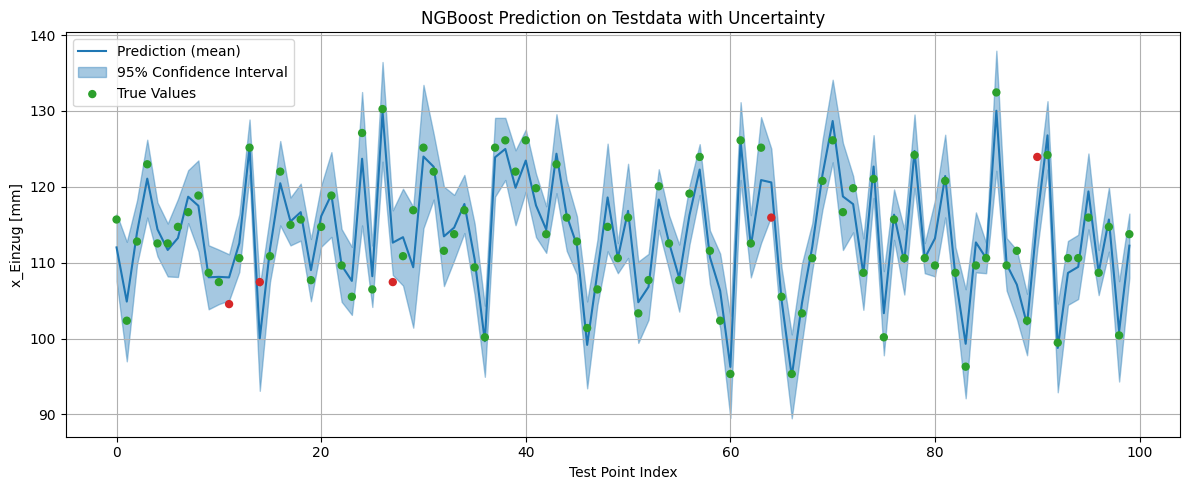

In [8]:
import numpy as np
import matplotlib.pyplot as plt
#import wandb
#wandb.login()

#! handling the train data
# Predicte mean and distribution for train and test data
y_train_preds = ngb.predict(X_train)
y_train_dists = ngb.pred_dist(X_train)

# print the negative log likelihood
print(f"nll_train: {-y_train_dists.logpdf(y_train).mean():.3f}")
# calculate the mean squared error
mse_train = mean_squared_error(y_train, y_train_preds)
print(f"Train MSE: {mse_train:.3f}")
# Calculate R² for the train data
r2_train = r2_score(y_train, y_train_preds)
print(f"R² on Train Data: {r2_train:.3f}")


#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Predict mean and distribution for test data
y_test_preds = ngb.predict(X_test)
y_test_dists = ngb.pred_dist(X_test)
# Extract standard deviation from test predictions
test_stddev = y_test_dists.scale

# print the negative log likelihood
print(f"nll_test: {-y_test_dists.logpdf(y_test).mean():.3f}")
# calculate the mean squared error
mse_test = mean_squared_error(y_test, y_test_preds)
print(f"Test MSE: {mse_test:.3f}")
# Calculate R² for the test data
r2_test = r2_score(y_test, y_test_preds)
print(f"R² on Test Data: {r2_test:.3f}")

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
ngboost_lower = y_test_preds - 2*test_stddev
ngboost_upper = y_test_preds + 2*test_stddev

# calculate the coverage of the confidence interval
in_interval = (y_test >= ngboost_lower) & (y_test <= ngboost_upper)
# number of true
counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value of the random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= ngboost_lower[random_indices]) & (y_test[random_indices] <= ngboost_upper[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Plotting the prediction with uncertainty and true values
fig = plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)

# Plot predicted mean
plt.plot(x_axis, y_test_preds[random_indices], label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, ngboost_lower[random_indices], ngboost_upper[random_indices],
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test[random_indices], label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("NGBoost Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# wandb.init(project="ngboost-fem-rauschen", config={
#     "n_estimators": 400,
#     "learning_rate": 0.01,
#     "distribution": "Normal",
#     "score": "LogScore",
#     "early_stopping_rounds": 2,
#     })

# wandb.log({"coverage": coverage})
# wandb.log({"R²": r2_test})
# wandb.log({"confidence_interval_plot": wandb.Image(fig)})

[6873 5130 6255 ...  402 3043 1975]
[ 65.      81.7435  83.9345 ... 127.3499 127.3499 127.3499]
[ 88.78584213  92.92870154 113.33160046 ... 121.46279274 122.70899614
 121.63707935]
Lowest lower bound: 36.16890382106944
Highest upper bound: 149.68849925757692
Highest difference between upper and lower bound: 113.51959543650747
Index of highest difference: 1


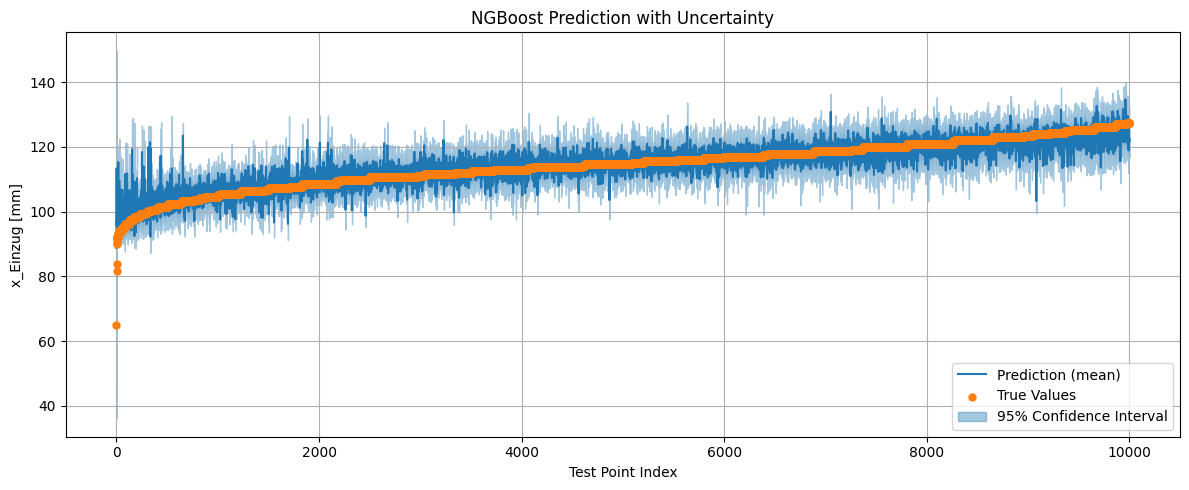

In [27]:
sort_idx = np.argsort(y_test)
print(sort_idx)
y_test_preds_sorted = y_test_preds[sort_idx]
test_stddev_sorted = test_stddev[sort_idx]
y_test_sorted = y_test[sort_idx]

n = 10000

ngb_mean_sorted = y_test_preds_sorted[:n]
ngb_std_sorted = test_stddev_sorted[:n]
y_test_sorted = y_test_sorted[:n]

print(y_test_sorted)
print(ngb_mean_sorted)
ngb_lower_bound_full = ngb_mean_sorted - 2 * ngb_std_sorted
ngb_upper_bound_full = ngb_mean_sorted + 2 * ngb_std_sorted
# print lowest of ngb_lower_bound_full and highest of ngb_upper_bound_full
print(f"Lowest lower bound: {np.min(ngb_lower_bound_full)}")
print(f"Highest upper bound: {np.max(ngb_upper_bound_full)}")

# print the highes difference between upper and lower bound and index of the highest difference
diff = ngb_upper_bound_full - ngb_lower_bound_full
print(f"Highest difference between upper and lower bound: {np.max(diff)}")
print(f"Index of highest difference: {np.argmax(diff)}")


# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(n)  # Create an index axis for plotting
# Plot the predicted mean
plt.plot(ngb_mean_sorted, label="Prediction (mean)", color='tab:blue')

# plot true values for the first 100 points
plt.scatter(x_axis, y_test_sorted, label="True Values", c='tab:orange', s=25, zorder=3)

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, ngb_lower_bound_full, ngb_upper_bound_full, alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')
# Final plot settings
plt.title("NGBoost Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Overview on the feature importance

                        feature  importance
33               Diff_Ziehtiefe    0.008092
28   Diff_Gegenhalterkraft_HL_1    0.006644
31   Diff_Gegenhalterkraft_VR_1    0.005637
30   Diff_Gegenhalterkraft_VL_1    0.005329
29   Diff_Gegenhalterkraft_HR_1    0.005118
35  Diff_Stoesselverstellung-mm    0.005012
36       Diff_Gewichtsausgleich    0.004020
8                         SD_10    0.002480
17                dayofweek_cos    0.002268
16                dayofweek_sin    0.002254
34   Diff_Ziehkissenverstellung    0.000788
19                    month_cos    0.000783
18                    month_sin    0.000202
25                  quarter_cos    0.000168
24                  quarter_sin    0.000096
15                   is_weekend    0.000028
                        feature  importance
35  Diff_Stoesselverstellung-mm    0.009674
31   Diff_Gegenhalterkraft_VR_1    0.008460
19                    month_cos    0.007940
28   Diff_Gegenhalterkraft_HL_1    0.007475
27                     week_cos 

Text(0.5, 1.0, 'std (scale param)')

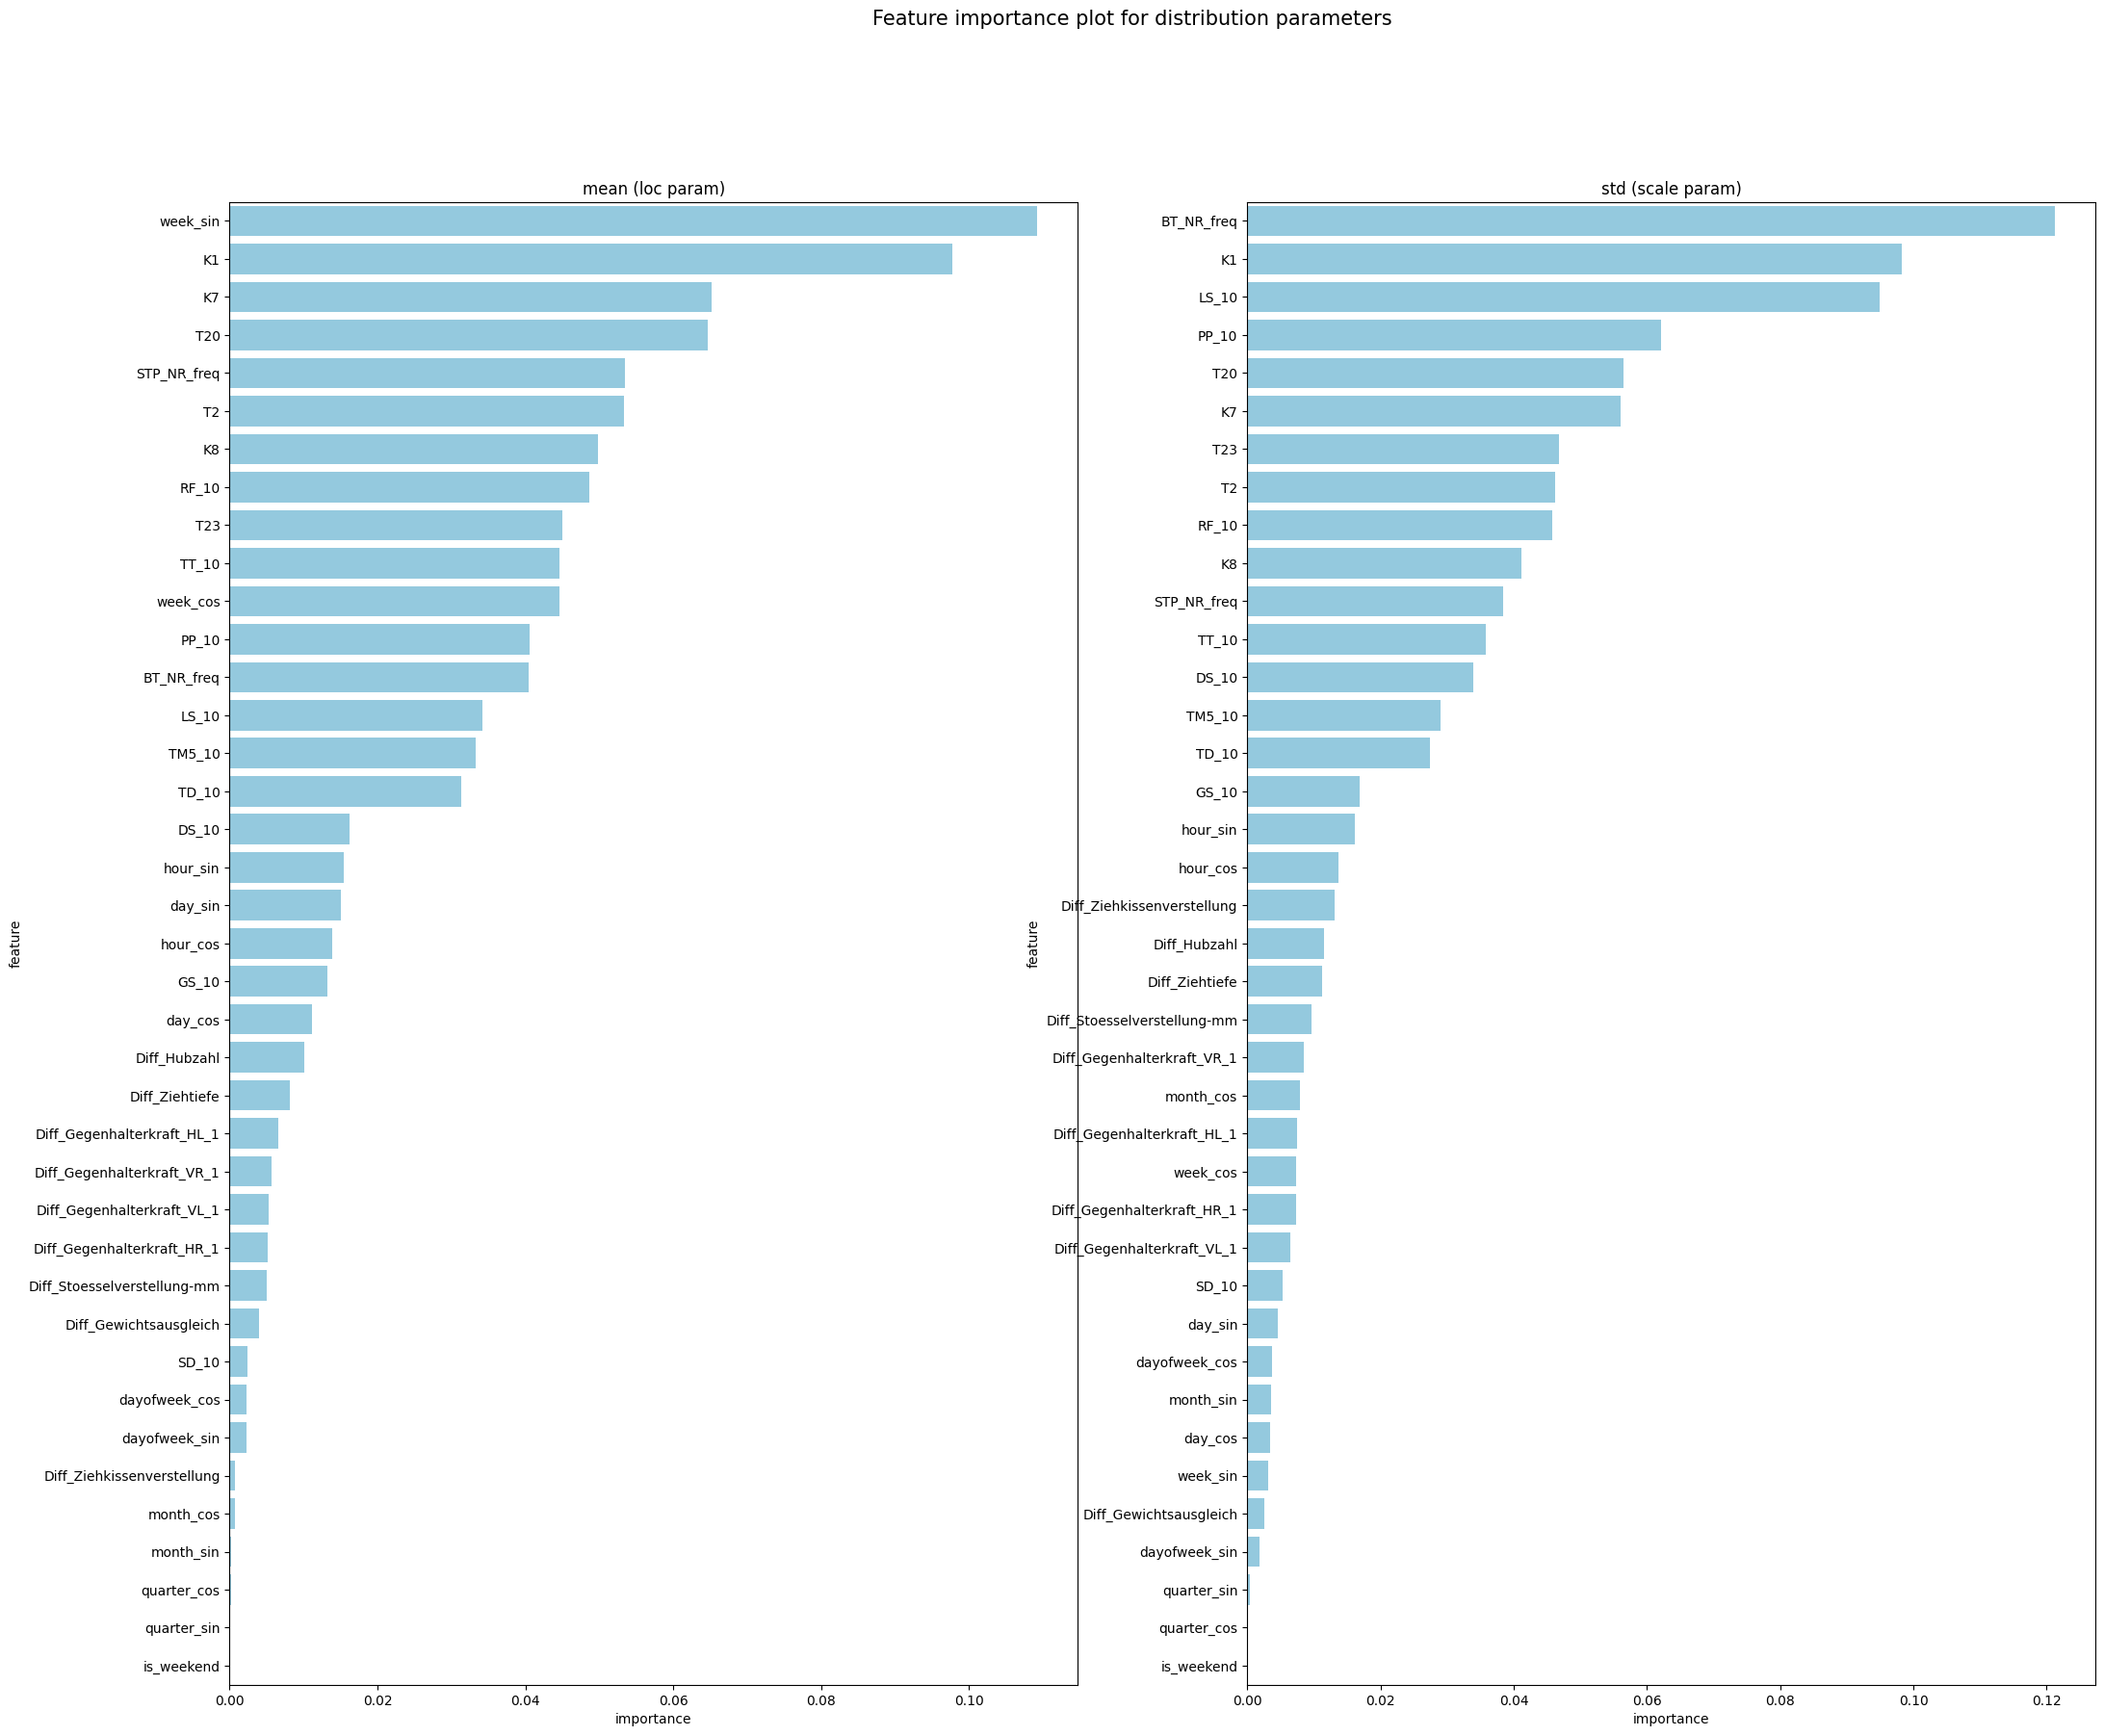

In [6]:
import seaborn as sns
## Feature importance for loc trees
feature_importance_loc = ngb.feature_importances_[0]

## Feature importance for scale trees
feature_importance_scale = ngb.feature_importances_[1]

#feature names baseline dataset
#['Matrizenradius [mm ]', 'Stempelkantenradius [mm]', 'Blechdicke [mm]',            'Platinenabmessung [mm]', '1/4 Niederhalterkraft [N]', 'Ziehtiefe [mm]']

df_loc = pd.DataFrame({
                        'feature':feature_names,
                        'importance':feature_importance_loc})\
                        .sort_values('importance',ascending=False)
    
df_scale = pd.DataFrame({
                        'feature':feature_names,
                        'importance':feature_importance_scale})\
                        .sort_values('importance',ascending=False)

df_loc_filtered = df_loc[df_loc['importance'] < 0.01]
df_scale_filtered = df_scale[df_scale['importance'] < 0.01]

print(df_loc_filtered)
print(df_scale_filtered)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,20))
fig.suptitle("Feature importance plot for distribution parameters", fontsize=15)
sns.barplot(x='importance',y='feature',ax=ax1,data=df_loc, color="skyblue").set_title('mean (loc param)')
sns.barplot(x='importance',y='feature',ax=ax2,data=df_scale, color="skyblue").set_title('std (scale param)')

Permutation Importance

Wie stark sinkt die Modell-Performance, wenn ein Feature zufällig durchmischt (permutiert) wird

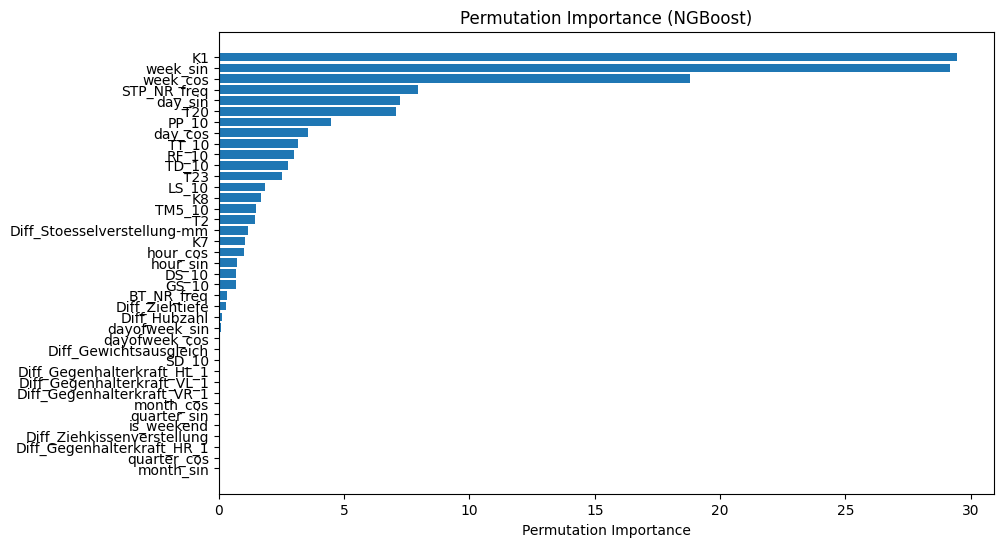

In [8]:
from sklearn.inspection import permutation_importance

result = permutation_importance(ngb, X_test, y_test, n_repeats=10, random_state=42, scoring = 'neg_mean_squared_error')

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.barh(np.array(feature_names)[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance (NGBoost)")
plt.show()


SHAP Interpretation:
„Wie viel trägt jedes Feature zur Abweichung der Vorhersage vom Durchschnitt bei?“

Dazu berechnet SHAP für jedes Feature und jeden Datenpunkt einen Wert, den SHAP-Wert, der quantifiziert:

positiver SHAP-Wert → dieses Feature hat die Vorhersage erhöht

negativer SHAP-Wert → dieses Feature hat die Vorhersage gesenkt

C:\Users\Surface\AppData\Local\Temp\ipykernel_18564\18836053.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, feature_names=feature_names, max_display=10)


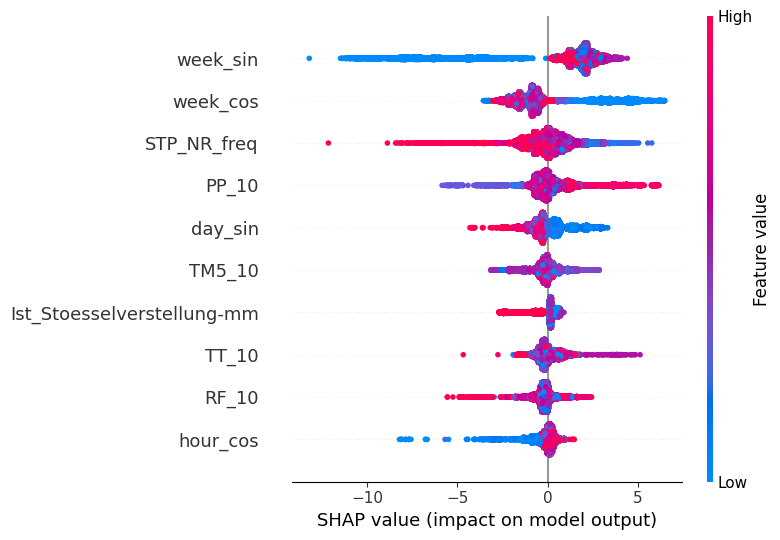

In [40]:
import shap
shap.initjs()

## SHAP plot for loc trees
explainer = shap.TreeExplainer(ngb, model_output=0) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=feature_names, max_display=10)